# Importing Libraries

In [219]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import os
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.autograd import Variable

# Device

In [196]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Loading Dataset

In [200]:
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/MyDrive/sing_minst/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('/content/drive/MyDrive/sing_minst/sign_mnist_test/sign_mnist_test.csv')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Images and Labels

In [201]:
train_labels = train['label']
train.drop('label',axis=1,inplace=True)

test_labels = test['label']
test.drop('label',axis=1, inplace=True)

train_data = train.values
train_labels = train_labels.values

test_data = test.values
test_labels = test_labels.values

<Axes: >

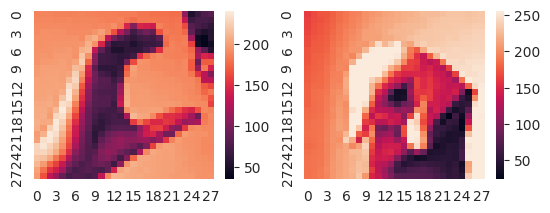

In [210]:
pixels = train_data[2].reshape(28,28)
plt.subplot(221)
sns.heatmap(data=pixels)
pixels = train_data[5].reshape(28,28)
plt.subplot(222)
sns.heatmap(data=pixels)

#Distribution of data

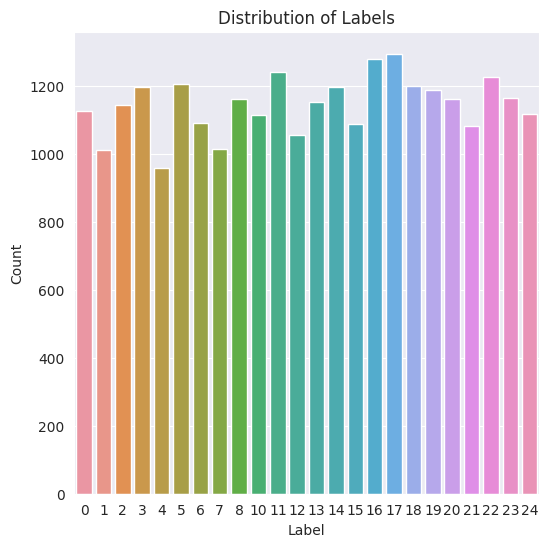

In [125]:
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.countplot(data=train,x='label')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

plt.show()

# Pre-processing

In [211]:
reshaped_train = []

for i in train_data:
  reshaped_train.append(i.reshape(1,28,28))
train_data = np.array(reshaped_train)
reshaped_test = []
for i in test_data:
    reshaped_test.append(i.reshape(1, 28,28))
test_data = np.array(reshaped_train)

train_x = torch.FloatTensor(train_data)
train_y = torch.LongTensor(train_labels.tolist())

test_x = torch.FloatTensor(train_data)
test_y = torch.LongTensor(train_labels.tolist())


# Model

In [225]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,20,3)
        self.conv3 = nn.Conv2d(20,30,3)

        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(0.2)

        self.fc1 = nn.Linear(30*3*3, 270)
        self.fc2 = nn.Linear(270,26)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = x.view(-1, 30 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.softmax(F.relu(self.fc2(x)))

        return(x)

    def test(self, predictions,labels):
        self.eval()
        correct = 0
        for p,l in zip(predictions,labels):
            if p==l:
                correct+=1
        acc = correct/len(predictions)
        return(acc, correct, len(predictions))

    def evaluate(self, predictions,labels):
        correct = 0
        for p,l in zip(predictions,labels):
            if p==l:
                correct+=1
        acc = correct/len(predictions)
        return(acc)

In [226]:
model  = Network()
model.to(device)


Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=270, out_features=270, bias=True)
  (fc2): Linear(in_features=270, out_features=26, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [227]:
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
         MaxPool2d-2           [-1, 10, 13, 13]               0
            Conv2d-3           [-1, 20, 11, 11]           1,820
         MaxPool2d-4             [-1, 20, 5, 5]               0
            Conv2d-5             [-1, 30, 3, 3]           5,430
         Dropout2d-6             [-1, 30, 3, 3]               0
            Linear-7                  [-1, 270]          73,170
            Linear-8                   [-1, 26]           7,046
        LogSoftmax-9                   [-1, 26]               0
Total params: 87,566
Trainable params: 87,566
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.33
Estimated Total Size (MB): 0.43
---------------------------------------------

# Loss & Gradient

In [228]:
epochs = 80
batch_size = 64
learning_rate = 0.001

optimizer = optim.SGD(model.parameters(),learning_rate,momentum=0.09)
loss_fn = nn.CrossEntropyLoss()


In [230]:
train_x.shape

torch.Size([27455, 1, 28, 28])

# Training

In [233]:
loss_log = []
acc_log = []
for e in range(epochs):
    for i in range(0,train_x.shape[0],100):

          x_batch = train_x[i:i+100]
          y_batch = train_y[i:i+100]

          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          test_x = test_x.to(device)
          test_y = test_y.to(device)

          optimizer.zero_grad()
          out = model(Variable(x_batch))
          loss = loss_fn(out,Variable(y_batch))
          loss.backward()
          optimizer.step()

          if i % 1000 ==0:
                loss_log.append(loss.item())
                acc_log.append(model.evaluate(torch.max(model(Variable(test_x[:500])).data, 1)[1], test_y[:500]))
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))


Epoch: 1 - Loss: 2.739620
Epoch: 2 - Loss: 2.216329
Epoch: 3 - Loss: 1.974249
Epoch: 4 - Loss: 1.738298
Epoch: 5 - Loss: 1.424565
Epoch: 6 - Loss: 1.417815
Epoch: 7 - Loss: 1.029513
Epoch: 8 - Loss: 0.878056
Epoch: 9 - Loss: 0.759117
Epoch: 10 - Loss: 0.752942
Epoch: 11 - Loss: 0.697875
Epoch: 12 - Loss: 0.577122
Epoch: 13 - Loss: 0.602959
Epoch: 14 - Loss: 0.548663
Epoch: 15 - Loss: 0.432002
Epoch: 16 - Loss: 0.363994
Epoch: 17 - Loss: 0.237942
Epoch: 18 - Loss: 0.407906
Epoch: 19 - Loss: 0.303890
Epoch: 20 - Loss: 0.329136
Epoch: 21 - Loss: 0.315722
Epoch: 22 - Loss: 0.153746
Epoch: 23 - Loss: 0.258005
Epoch: 24 - Loss: 0.120594
Epoch: 25 - Loss: 0.223308
Epoch: 26 - Loss: 0.032537
Epoch: 27 - Loss: 0.068808
Epoch: 28 - Loss: 0.073013
Epoch: 29 - Loss: 0.026370
Epoch: 30 - Loss: 0.052802
Epoch: 31 - Loss: 0.103265
Epoch: 32 - Loss: 0.089270
Epoch: 33 - Loss: 0.067743
Epoch: 34 - Loss: 0.021894
Epoch: 35 - Loss: 0.040215
Epoch: 36 - Loss: 0.116054
Epoch: 37 - Loss: 0.011792
Epoch: 38 

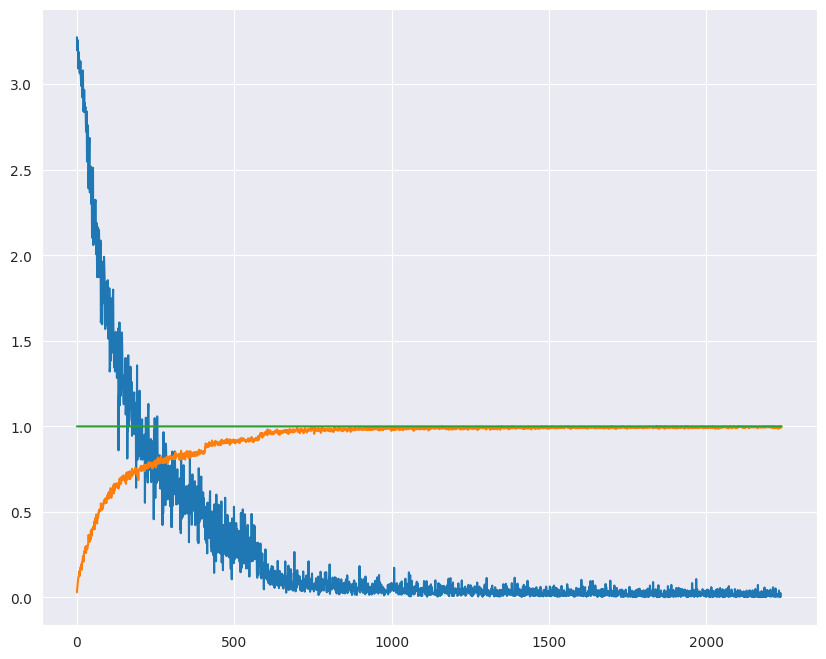

In [235]:
plt.figure(figsize=(10,8))
plt.plot(loss_log[2:])
plt.plot(acc_log)
plt.plot(np.ones(len(acc_log)))
plt.show()

In [236]:
predictions = model(Variable(test_x))
accuracy, correct, total = model.test(torch.max(predictions.data, 1)[1], test_y)
print("Accuracy = " + str(accuracy) + " ("+str(correct)+"/"+str(total)+")")

Accuracy = 0.9949007466763795 (27315/27455)


# Saving the Model

In [237]:
torch.save(model, 'model_trained.pt')